### Importing necessary packages and data

In [ ]:
import pandas as pd
import os
from glob import glob

# Set folder path
folder_path = "c:/Users/Owner/Downloads/Data/Extracted Files"
csv_files = glob(os.path.join(folder_path, "*.csv"))

# Define correct column names
columns = [
    "ride_id", "rideable_type", "started_at", "ended_at",
    "start_station_name", "start_station_id", "end_station_name", "end_station_id",
    "start_lat", "start_lng", "end_lat", "end_lng", "member_casual"
]

dfs = []
for file in csv_files:
    df = pd.read_csv(file, names=columns, header=0, on_bad_lines='skip')

    # Remove rows where 'started_at' is literally the string "started_at"
    df = df[df["started_at"] != "started_at"]

    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

### Data Cleaning and Preprocessing

In [ ]:
df_all["started_at"] = pd.to_datetime(df_all["started_at"], format='mixed')
df_all["ended_at"] = pd.to_datetime(df_all["ended_at"], format='mixed')

In [89]:
# Convert lat/lng to float
latlng_cols = ["start_lat", "start_lng", "end_lat", "end_lng"]
df_all[latlng_cols] = df_all[latlng_cols].apply(pd.to_numeric, errors="coerce")

# Convert categories
cat_cols = [
    "ride_id", "rideable_type", "start_station_name", "start_station_id",
    "end_station_name", "end_station_id", "member_casual"
]
df_all[cat_cols] = df_all[cat_cols].astype("category")

In [90]:
print(df_all.dtypes)

ride_id                     category
rideable_type               category
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name          category
start_station_id            category
end_station_name            category
end_station_id              category
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual               category
dtype: object


In [91]:
null_summary = df_all.isnull().sum().to_frame(name='null_count')
null_summary['null_percent'] = (null_summary['null_count'] / len(df_all)) * 100
print(null_summary)

                    null_count  null_percent
ride_id                      0      0.000000
rideable_type                0      0.000000
started_at                   0      0.000000
ended_at                     0      0.000000
start_station_name     1936526     22.127806
start_station_id       1936526     22.127806
end_station_name       2000386     22.857505
end_station_id         2002544     22.882164
start_lat                    0      0.000000
start_lng                    0      0.000000
end_lat                   6241      0.071313
end_lng                   6241      0.071313
member_casual                0      0.000000


In [92]:
null_summary = df_all.isnull().sum().to_frame(name='null_count')
null_summary['null_percent'] = (null_summary['null_count'] / len(df_all)) * 100
print(null_summary)

                    null_count  null_percent
ride_id                      0      0.000000
rideable_type                0      0.000000
started_at                   0      0.000000
ended_at                     0      0.000000
start_station_name     1936526     22.127806
start_station_id       1936526     22.127806
end_station_name       2000386     22.857505
end_station_id         2002544     22.882164
start_lat                    0      0.000000
start_lng                    0      0.000000
end_lat                   6241      0.071313
end_lng                   6241      0.071313
member_casual                0      0.000000


In [93]:
df_all.shape

(8751550, 13)

In [94]:
# Columns to drop (not needed for demand forecasting)
drop_cols = [
    "ride_id", "ended_at",
    "end_station_name", "end_station_id",
    "start_lat", "start_lng", "end_lat", "end_lng"
]

# Create a separate DataFrame for dropped columns
df_dropped = df_all[drop_cols].copy()

# Create the modeling-ready DataFrame
df_useful = df_all.drop(columns=drop_cols).copy()


In [95]:
df_useful["hour_dt"] = df_useful["started_at"].dt.ceil("H")


C:\Users\Owner\AppData\Local\Temp\ipykernel_22652\3409381548.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_useful["hour_dt"] = df_useful["started_at"].dt.ceil("H")


In [96]:
df_useful.head(5)

,rideable_type,started_at,start_station_name,start_station_id,member_casual,hour_dt
0,classic_bike,2024-01-25 15:49:59,1st & O St NW,31519.0,member,2024-01-25 16:00:00
1,classic_bike,2024-01-02 16:44:58,1st & O St NW,31519.0,member,2024-01-02 17:00:00
2,classic_bike,2024-01-24 15:40:15,1st & O St NW,31519.0,member,2024-01-24 16:00:00
3,classic_bike,2024-01-04 15:35:00,1st & O St NW,31519.0,member,2024-01-04 16:00:00
4,electric_bike,2024-01-05 12:27:58,1st & O St NW,31519.0,casual,2024-01-05 13:00:00


In [97]:
df_dropped["started_at"] = df_useful["started_at"]


drop_cols = [
    "started_at"
]
df_final = df_useful.drop(columns=drop_cols).copy()

In [98]:
df_final.head(5)

,rideable_type,start_station_name,start_station_id,member_casual,hour_dt
0,classic_bike,1st & O St NW,31519.0,member,2024-01-25 16:00:00
1,classic_bike,1st & O St NW,31519.0,member,2024-01-02 17:00:00
2,classic_bike,1st & O St NW,31519.0,member,2024-01-24 16:00:00
3,classic_bike,1st & O St NW,31519.0,member,2024-01-04 16:00:00
4,electric_bike,1st & O St NW,31519.0,casual,2024-01-05 13:00:00


In [99]:
# Count number of rides per hour
df_demand = df_final.groupby("hour_dt").size().reset_index(name="ride_count")


In [100]:
df_demand.head()

,hour_dt,ride_count
0,2024-01-01 01:00:00,272
1,2024-01-01 02:00:00,324
2,2024-01-01 03:00:00,237
3,2024-01-01 04:00:00,60
4,2024-01-01 05:00:00,26


### Importing, Cleaning and preprocessing the Weather Data

In [101]:
weather_path = "c:/Users/Owner/Downloads/Data/cleaned_weather_data.csv"
df_weather = pd.read_csv(weather_path)

In [102]:
df_weather.dtypes

hour_dt                      object
temperature_2m (°C)         float64
precipitation (mm)          float64
wind_speed_10m (km/h)       float64
relative_humidity_2m (%)      int64
weather_code                 object
dtype: object

In [103]:
null_summary = df_weather.isnull().sum().to_frame(name='null_count')
null_summary['null_percent'] = (null_summary['null_count'] / len(df_weather)) * 100
print(null_summary)

                          null_count  null_percent
hour_dt                            0           0.0
temperature_2m (°C)                0           0.0
precipitation (mm)                 0           0.0
wind_speed_10m (km/h)              0           0.0
relative_humidity_2m (%)           0           0.0
weather_code                       0           0.0


In [104]:
df_weather["hour_dt"] = pd.to_datetime(df_weather["hour_dt"], format='mixed')
df_weather["weather_code"] = df_weather["weather_code"].astype("category")

In [106]:
df_weather.head()

,hour_dt,temperature_2m (°C),precipitation (mm),wind_speed_10m (km/h),relative_humidity_2m (%),weather_code
0,2024-01-01 00:00:00,1.8,0.0,7.3,88,Good
1,2024-01-01 01:00:00,2.3,0.0,5.4,88,Good
2,2024-01-01 02:00:00,0.9,0.0,6.6,91,Good
3,2024-01-01 03:00:00,0.9,0.0,6.0,92,Good
4,2024-01-01 04:00:00,0.6,0.0,5.8,92,Good


In [109]:
df_weather.shape

(12408, 6)

### Merging both demand and weather data

In [110]:
df_model = pd.merge(df_demand, df_weather, on="hour_dt", how="right")

In [112]:
df_model.head()

,hour_dt,ride_count,temperature_2m (°C),precipitation (mm),wind_speed_10m (km/h),relative_humidity_2m (%),weather_code
0,2024-01-01 00:00:00,NaN,1.8,0.0,7.3,88,Good
1,2024-01-01 01:00:00,272.0,2.3,0.0,5.4,88,Good
2,2024-01-01 02:00:00,324.0,0.9,0.0,6.6,91,Good
3,2024-01-01 03:00:00,237.0,0.9,0.0,6.0,92,Good
4,2024-01-01 04:00:00,60.0,0.6,0.0,5.8,92,Good


### Preprocessing the Merged data

In [113]:
null_summary = df_model.isnull().sum().to_frame(name='null_count')
null_summary['null_percent'] = (null_summary['null_count'] / len(df_model)) * 100
print(null_summary)

                          null_count  null_percent
hour_dt                            0      0.000000
ride_count                         3      0.024178
temperature_2m (°C)                0      0.000000
precipitation (mm)                 0      0.000000
wind_speed_10m (km/h)              0      0.000000
relative_humidity_2m (%)           0      0.000000
weather_code                       0      0.000000


In [116]:
df_model = df_model.drop('weather_code', axis=1)
df_model.fillna(0, inplace=True)

In [117]:
null_summary = df_model.isnull().sum().to_frame(name='null_count')
null_summary['null_percent'] = (null_summary['null_count'] / len(df_model)) * 100
print(null_summary)

                          null_count  null_percent
hour_dt                            0           0.0
ride_count                         0           0.0
temperature_2m (°C)                0           0.0
precipitation (mm)                 0           0.0
wind_speed_10m (km/h)              0           0.0
relative_humidity_2m (%)           0           0.0


In [148]:
df_model.head(5)

df_model.to_csv("c:/Users/Owner/Downloads/Data/cleaned.csv", index=False)

### Training the Prophet model on the first 95% of data

In [118]:
df_prophet = df_model.rename(columns={"hour_dt": "ds", "ride_count": "y"})

In [119]:
split_idx = int(len(df_prophet) * 0.95)
train_df = df_prophet.iloc[:split_idx]
test_df = df_prophet.iloc[split_idx:]


In [120]:
from prophet import Prophet

model = Prophet()
model.add_regressor("temperature_2m (°C)")
model.add_regressor("wind_speed_10m (km/h)")
model.add_regressor("relative_humidity_2m (%)")
model.add_regressor("precipitation (mm)")

model.fit(train_df)


02:14:24 - cmdstanpy - INFO - Chain [1] start processing
02:14:26 - cmdstanpy - INFO - Chain [1] done processing


### Predicting the demand for the remaining 5% data with the help of the weather data

In [ ]:
future = model.make_future_dataframe(periods=len(test_df), freq="H")
future = pd.merge(future, df_prophet.drop(columns="y"), on="ds", how="left")  # Add weather to future


In [122]:
forecast = model.predict(future)

# Merge actual ride counts for comparison
forecast = forecast.merge(df_prophet[["ds", "y"]], on="ds", how="left")

# Evaluate on test set
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = forecast["y"].iloc[split_idx:]
y_pred = forecast["yhat"].iloc[split_idx:]

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


MAE: 302.53, RMSE: 362.44


c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [125]:
# Join predictions with actual values
df_forecast = forecast[["ds", "yhat"]].merge(df_prophet[["ds", "y"]], on="ds", how="left")


In [126]:
split_idx = int(len(df_prophet) * 0.95)
df_test = df_forecast.iloc[split_idx:]


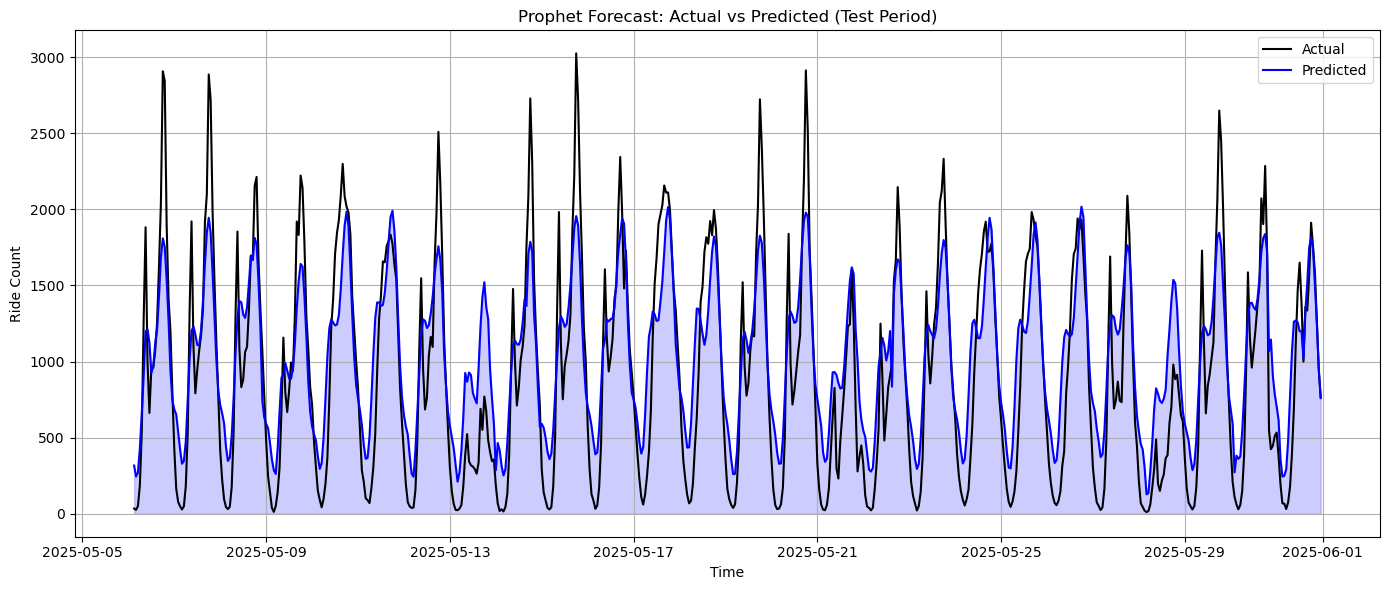

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(df_test["ds"], df_test["y"], label="Actual", color="black")
plt.plot(df_test["ds"], df_test["yhat"], label="Predicted", color="blue")
plt.fill_between(df_test["ds"], df_test["yhat"], alpha=0.2, color="blue")
plt.title("Prophet Forecast: Actual vs Predicted (Test Period)")
plt.xlabel("Time")
plt.ylabel("Ride Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The model failed to capture the peaks properly. Let's integrate XGBoost with the residuals of Prophet model.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(df_test["y"], df_test["yhat"])
rmse = mean_squared_error(df_test["y"], df_test["yhat"], squared=False)
r2 = r2_score(df_test["y"], df_test["yhat"])


In [131]:
print(mae, rmse, r2)

302.5252132941739 362.4445018926702 0.7393732590075445


### Training XGBoost model with the help of Prophet's residuals

In [132]:
# Merge forecast with actuals and original features
df_forecast = forecast[["ds", "yhat"]].merge(df_prophet, on="ds", how="left")

# Add Prophet residual
df_forecast["residual"] = df_forecast["y"] - df_forecast["yhat"]

# Optional: create lag/rolling features
df_forecast["yhat_lag1"] = df_forecast["yhat"].shift(1)
df_forecast["yhat_rolling3"] = df_forecast["yhat"].rolling(3).mean()
df_forecast["hour"] = df_forecast["ds"].dt.hour
df_forecast["dayofweek"] = df_forecast["ds"].dt.dayofweek


In [133]:
df_xgb = df_forecast.dropna()


In [134]:
split_idx = int(len(df_xgb) * 0.95)
train_xgb = df_xgb.iloc[:split_idx]
test_xgb = df_xgb.iloc[split_idx:]


In [137]:
train_xgb

,ds,yhat,y,temperature_2m (°C),precipitation (mm),wind_speed_10m (km/h),relative_humidity_2m (%),residual,yhat_lag1,yhat_rolling3,hour,dayofweek
2,2024-01-01 02:00:00,-279.982595,324.0,0.9,0.0,6.6,91,603.982595,-152.053065,-185.235677,2,0
3,2024-01-01 03:00:00,-384.300615,237.0,0.9,0.0,6.0,92,621.300615,-279.982595,-272.112092,3,0
4,2024-01-01 04:00:00,-463.256274,60.0,0.6,0.0,5.8,92,523.256274,-384.300615,-375.846495,4,0
5,2024-01-01 05:00:00,-452.711882,26.0,1.1,0.6,7.3,91,478.711882,-463.256274,-433.422924,5,0
6,2024-01-01 06:00:00,-236.766996,31.0,1.9,0.2,4.7,90,267.766996,-452.711882,-384.245051,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11782,2025-05-05 22:00:00,696.902840,279.0,16.5,1.2,15.4,94,-417.902840,919.977478,984.333426,22,0
11783,2025-05-05 23:00:00,253.142229,356.0,16.3,10.4,6.8,96,102.857771,696.902840,623.340849,23,0
11784,2025-05-06 00:00:00,343.276908,204.0,16.4,5.3,8.7,96,-139.276908,253.142229,431.107326,0,1
11785,2025-05-06 01:00:00,421.424813,121.0,15.8,2.6,3.5,96,-300.424813,343.276908,339.281317,1,1


In [138]:
from xgboost import XGBRegressor

features = ["yhat", "temperature_2m (°C)", "relative_humidity_2m (%)", "wind_speed_10m (km/h)", "precipitation (mm)", "hour", "dayofweek", "yhat_lag1", "yhat_rolling3"]

X_train = train_xgb[features]
y_train = train_xgb["residual"]

X_test = test_xgb[features]
y_test = test_xgb["residual"]

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [139]:
# Predict residuals
residual_pred = xgb_model.predict(X_test)

# Final prediction = Prophet forecast + XGBoost residual correction
final_pred = test_xgb["yhat"].values + residual_pred

# Evaluate
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_xgb["y"], final_pred)
rmse = mean_squared_error(test_xgb["y"], final_pred, squared=False)
r2 = r2_score(test_xgb["y"], final_pred)

print(f"Hybrid MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


Hybrid MAE: 153.49, RMSE: 237.63, R²: 0.8880


c:\Users\Owner\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



### Final prediction

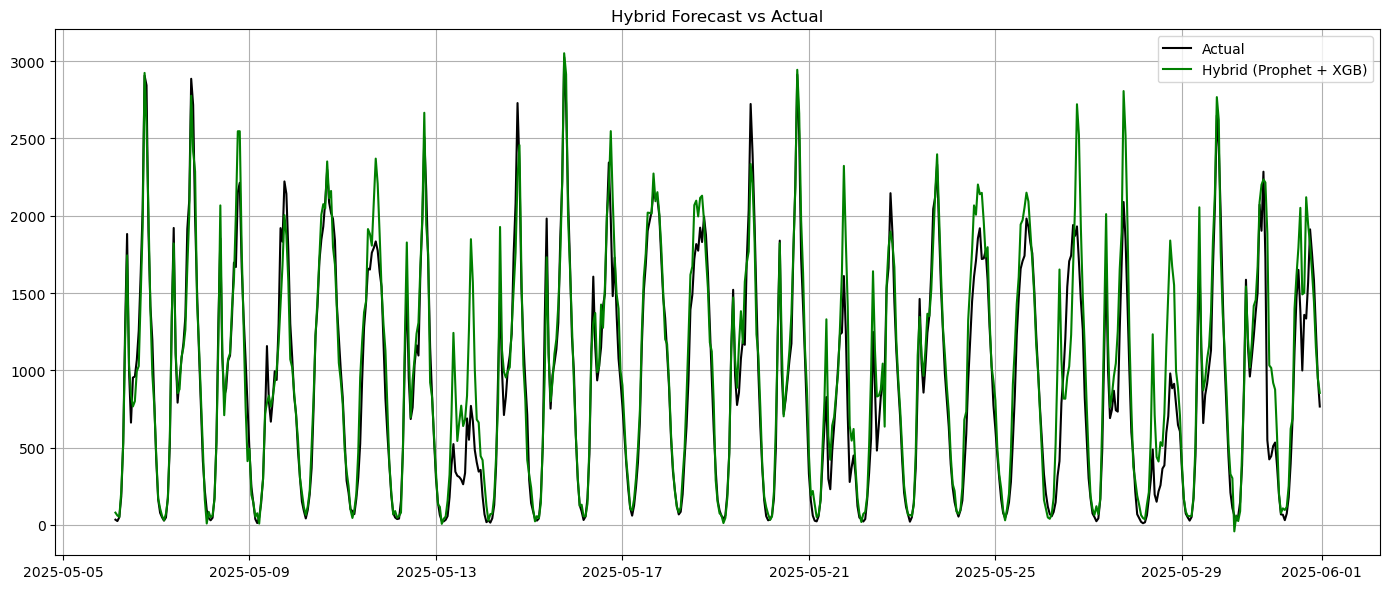

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(test_xgb["ds"], test_xgb["y"], label="Actual", color="black")
#plt.plot(test_xgb["ds"], test_xgb["yhat"], label="Prophet", color="blue")
plt.plot(test_xgb["ds"], final_pred, label="Hybrid (Prophet + XGB)", color="green")
plt.title("Hybrid Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
